In [2023]:
import pandas as pd
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

import mlflow
import mlflow.sklearn
from datetime import datetime
import json
from sklearn.metrics import silhouette_score, calinski_harabasz_score


In [2024]:
# Set up MLflow tracking
mlflow.set_tracking_uri("file:///C:/Users/saraf/OneDrive/Documentos/Data Science and AI/capstone project/mlruns")
mlflow.set_experiment("student_clustering_analysis")

<Experiment: artifact_location=('file:///C:/Users/saraf/OneDrive/Documentos/Data Science and AI/capstone '
 'project/mlruns/631377474132619137'), creation_time=1749301628353, experiment_id='631377474132619137', last_update_time=1749301628353, lifecycle_stage='active', name='student_clustering_analysis', tags={}>

In [2025]:
# leemos el dataset limpio de partida, con las columas con las que vamos a trabajar

df_students_clean = pd.read_csv('C:\\Users\\saraf\\OneDrive\\Documentos\\Data Science and AI\\capstone project\\data\\df_students_clean.csv')

df_students_clean.head()

,ST267Q01JA,ST267Q02JA,ST267Q03JA,ST267Q04JA,ST267Q05JA,ST267Q06JA,ST267Q07JA,ST267Q08JA,ST270Q01JA,ST270Q02JA,ST270Q03JA,ST270Q04JA,ST297Q01JA,ST300Q01JA,ST300Q02JA,ST300Q03JA,ST300Q04JA,ST300Q05JA,ST300Q06JA,ST300Q07JA,ST300Q08JA,ST300Q09JA,ST300Q10JA,ST348Q04JA,ST348Q08JA,ST353Q01JA,ST353Q02JA,ST353Q05JA,ST353Q06JA,ST353Q07JA,ST353Q08JA,PA003Q01TA,PA003Q18WA,PA003Q05IA,PA003Q20WA,PA003Q12JA,PA008Q01TA,PA008Q02TA,PA008Q03TA,PA008Q04TA,...,WB155Q08HA,WB155Q09HA,WB163Q01HA,WB163Q02HA,WB163Q03HA,WB163Q04HA,WB163Q05HA,WB163Q06HA,WB163Q07HA,WB163Q08HA,PV1MATH,PV2MATH,PV3MATH,PV4MATH,PV5MATH,PV6MATH,PV7MATH,PV8MATH,PV9MATH,PV10MATH,PV1READ,PV2READ,PV3READ,PV4READ,PV5READ,PV6READ,PV7READ,PV8READ,PV9READ,PV10READ,PV1SCIE,PV2SCIE,PV3SCIE,PV4SCIE,PV5SCIE,PV6SCIE,PV7SCIE,PV8SCIE,PV9SCIE,PV10SCIE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,498.564,496.437,461.107,413.795,468.306,474.359,440.060,466.289,501.799,498.667,448.468,430.204,427.666,467.043,506.138,456.182,495.261,436.598,455.164,431.586,506.912,520.943,445.915,447.578,510.355,469.425,485.229,520.293,509.465,520.461
1,Agree,Disagree,NaN,NaN,Agree,Strongly agree,Agree,NaN,Some lessons,Some lessons,Most lessons,Some lessons,Not Checked,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Totally satisfied,Satisfied,Almost always,Almost always,Almost always,Almost always,Almost always,Almost never,Almost never,Almost always,487.555,463.191,556.850,468.725,498.460,489.506,520.003,448.336,456.592,559.451,527.749,550.748,545.087,528.339,507.892,522.393,564.715,560.937,554.602,512.845,472.056,497.419,583.550,486.117,543.515,501.654,522.876,518.897,540.951,555.862
2,NaN,Agree,Agree,NaN,Agree,Agree,NaN,Disagree,Some lessons,Some lessons,Some lessons,Some lessons,Not Checked,Every day or almost every day,NaN,Every day or almost every day,Every day or almost every day,NaN,Every day or almost every day,NaN,NaN,Every day or almost every day,NaN,NaN,Every day or almost every day,A few times,Every day or almost every day,NaN,Never,Never,Never,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Satisfied,Satisfied,Sometimes,Sometimes,Almost always,Almost always,Sometimes,Sometimes,Almost never,Almost always,298.642,340.790,334.073,348.531,292.141,316.104,319.801,328.778,315.272,284.522,413.123,325.643,312.483,360.927,344.364,334.633,347.122,343.097,368.747,334.109,336.125,383.288,390.317,360.386,389.356,424.082,377.563,422.321,363.447,431.934
3,Agree,Disagree,Agree,Strongly disagree,NaN,NaN,Agree,NaN,Every lesson,Every lesson,Every lesson,Every lesson,Not Checked,NaN,NaN,Every day or almost every day,NaN,NaN,About once or twice a week,Every day or almost every day,About once or twice a week,Every day or almost every day,NaN,NaN,A few times,NaN,Every day or almost every day,Every day or almost every day,Never,About once or twice a week,Never,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Totally satisfied,Satisfied,Almost always,Sometimes,Almost always,Almost always,Almost always,Almost never,Sometimes,Almost always,381.872,355.081,373.648,374.194,361.886,401.721,353.348,398.381,369.926,355.299,436.717,400.287,413.180,446.061,433.482,408.833,394.058,415.046,437.632,461.843,413.822,324.202,343.227,284.083,330.103,351.840,353.562,381.369,366.970,350.518
4,NaN,Strongly disagree,Strongly disagree,NaN,Strongly disagree,Strongly disagree,NaN,Agree,Most lessons,Most lessons,Most lessons,Every lesson,Checked,Every day or almost every day,Every day or almost every day,NaN,NaN,Every day or almost every day,Never or almost never,NaN,NaN,About once or twice a week,NaN,Every day or almost every day,NaN,NaN,About once or twice a week,About once or twice a week,A few times,NaN,A few times,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Satisfied,Satisfied,Almost always,Almost always,Almost always,Almost always,Almost a

In [2026]:
df_students_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30800 entries, 0 to 30799
Data columns (total 88 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ST267Q01JA  18516 non-null  object 
 1   ST267Q02JA  18403 non-null  object 
 2   ST267Q03JA  18464 non-null  object 
 3   ST267Q04JA  18378 non-null  object 
 4   ST267Q05JA  18545 non-null  object 
 5   ST267Q06JA  18283 non-null  object 
 6   ST267Q07JA  18381 non-null  object 
 7   ST267Q08JA  18550 non-null  object 
 8   ST270Q01JA  28806 non-null  object 
 9   ST270Q02JA  28746 non-null  object 
 10  ST270Q03JA  28756 non-null  object 
 11  ST270Q04JA  28769 non-null  object 
 12  ST297Q01JA  29406 non-null  object 
 13  ST300Q01JA  13422 non-null  object 
 14  ST300Q02JA  13490 non-null  object 
 15  ST300Q03JA  13511 non-null  object 
 16  ST300Q04JA  13298 non-null  object 
 17  ST300Q05JA  13332 non-null  object 
 18  ST300Q06JA  13293 non-null  object 
 19  ST300Q07JA  13398 non-nul

In [2027]:
def obtener_significado(codigo, df_compendio):
    resultado = df_compendio.loc[df_compendio['Sigla'] == codigo, 'Explicacion']
    return resultado.iloc[0] if not resultado.empty else "Not found"

In [2028]:
compendio = pd.read_excel('compendio_df_students.xlsx')

Imprimimos las columnas con las que estamos trabajando

In [2029]:
for column in df_students_clean.columns:
    print(f"{column}: {obtener_significado(column, compendio)}")

ST267Q01JA: Agree/disagree: The teachers at my school are respectful towards me.
ST267Q02JA: Agree/disagree: If I walked into my classes upset, my teachers would be concerned about me.
ST267Q03JA: Agree/disagree: If I came back to visit my school 3 years from now, my teachers would be excited to see me.
ST267Q04JA: Agree/disagree: I feel intimidated by the teachers at my school.
ST267Q05JA: Agree/disagree: When my teachers ask how I am doing, they are really interested in my answer.
ST267Q06JA: Agree/disagree: The teachers at my school are friendly towards me.
ST267Q07JA: Agree/disagree: The teachers at my school are interested in students' well-being.
ST267Q08JA: Agree/disagree: The teachers at my school are mean towards me.
ST270Q01JA: How often: The teacher shows an interest in every student's learning.
ST270Q02JA: How often: The teacher gives extra help when students need it.
ST270Q03JA: How often: The teacher helps students with their learning.
ST270Q04JA: How often: The teacher c

In [2030]:
df_students_clean.head()

,ST267Q01JA,ST267Q02JA,ST267Q03JA,ST267Q04JA,ST267Q05JA,ST267Q06JA,ST267Q07JA,ST267Q08JA,ST270Q01JA,ST270Q02JA,ST270Q03JA,ST270Q04JA,ST297Q01JA,ST300Q01JA,ST300Q02JA,ST300Q03JA,ST300Q04JA,ST300Q05JA,ST300Q06JA,ST300Q07JA,ST300Q08JA,ST300Q09JA,ST300Q10JA,ST348Q04JA,ST348Q08JA,ST353Q01JA,ST353Q02JA,ST353Q05JA,ST353Q06JA,ST353Q07JA,ST353Q08JA,PA003Q01TA,PA003Q18WA,PA003Q05IA,PA003Q20WA,PA003Q12JA,PA008Q01TA,PA008Q02TA,PA008Q03TA,PA008Q04TA,...,WB155Q08HA,WB155Q09HA,WB163Q01HA,WB163Q02HA,WB163Q03HA,WB163Q04HA,WB163Q05HA,WB163Q06HA,WB163Q07HA,WB163Q08HA,PV1MATH,PV2MATH,PV3MATH,PV4MATH,PV5MATH,PV6MATH,PV7MATH,PV8MATH,PV9MATH,PV10MATH,PV1READ,PV2READ,PV3READ,PV4READ,PV5READ,PV6READ,PV7READ,PV8READ,PV9READ,PV10READ,PV1SCIE,PV2SCIE,PV3SCIE,PV4SCIE,PV5SCIE,PV6SCIE,PV7SCIE,PV8SCIE,PV9SCIE,PV10SCIE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,498.564,496.437,461.107,413.795,468.306,474.359,440.060,466.289,501.799,498.667,448.468,430.204,427.666,467.043,506.138,456.182,495.261,436.598,455.164,431.586,506.912,520.943,445.915,447.578,510.355,469.425,485.229,520.293,509.465,520.461
1,Agree,Disagree,NaN,NaN,Agree,Strongly agree,Agree,NaN,Some lessons,Some lessons,Most lessons,Some lessons,Not Checked,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Totally satisfied,Satisfied,Almost always,Almost always,Almost always,Almost always,Almost always,Almost never,Almost never,Almost always,487.555,463.191,556.850,468.725,498.460,489.506,520.003,448.336,456.592,559.451,527.749,550.748,545.087,528.339,507.892,522.393,564.715,560.937,554.602,512.845,472.056,497.419,583.550,486.117,543.515,501.654,522.876,518.897,540.951,555.862
2,NaN,Agree,Agree,NaN,Agree,Agree,NaN,Disagree,Some lessons,Some lessons,Some lessons,Some lessons,Not Checked,Every day or almost every day,NaN,Every day or almost every day,Every day or almost every day,NaN,Every day or almost every day,NaN,NaN,Every day or almost every day,NaN,NaN,Every day or almost every day,A few times,Every day or almost every day,NaN,Never,Never,Never,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Satisfied,Satisfied,Sometimes,Sometimes,Almost always,Almost always,Sometimes,Sometimes,Almost never,Almost always,298.642,340.790,334.073,348.531,292.141,316.104,319.801,328.778,315.272,284.522,413.123,325.643,312.483,360.927,344.364,334.633,347.122,343.097,368.747,334.109,336.125,383.288,390.317,360.386,389.356,424.082,377.563,422.321,363.447,431.934
3,Agree,Disagree,Agree,Strongly disagree,NaN,NaN,Agree,NaN,Every lesson,Every lesson,Every lesson,Every lesson,Not Checked,NaN,NaN,Every day or almost every day,NaN,NaN,About once or twice a week,Every day or almost every day,About once or twice a week,Every day or almost every day,NaN,NaN,A few times,NaN,Every day or almost every day,Every day or almost every day,Never,About once or twice a week,Never,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Totally satisfied,Satisfied,Almost always,Sometimes,Almost always,Almost always,Almost always,Almost never,Sometimes,Almost always,381.872,355.081,373.648,374.194,361.886,401.721,353.348,398.381,369.926,355.299,436.717,400.287,413.180,446.061,433.482,408.833,394.058,415.046,437.632,461.843,413.822,324.202,343.227,284.083,330.103,351.840,353.562,381.369,366.970,350.518
4,NaN,Strongly disagree,Strongly disagree,NaN,Strongly disagree,Strongly disagree,NaN,Agree,Most lessons,Most lessons,Most lessons,Every lesson,Checked,Every day or almost every day,Every day or almost every day,NaN,NaN,Every day or almost every day,Never or almost never,NaN,NaN,About once or twice a week,NaN,Every day or almost every day,NaN,NaN,About once or twice a week,About once or twice a week,A few times,NaN,A few times,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Satisfied,Satisfied,Almost always,Almost always,Almost always,Almost always,Almost a

## Preprocesado inicial

Descartamos columnas vacías

In [2031]:
# descartar columnas que empiezan por PA

df_students_clean = df_students_clean.drop(df_students_clean.filter(regex='^PA').columns, axis=1)



In [2032]:
df_students_clean.shape

(30800, 71)

In [2033]:
df_students_clean.columns

Index(['ST267Q01JA', 'ST267Q02JA', 'ST267Q03JA', 'ST267Q04JA', 'ST267Q05JA',
       'ST267Q06JA', 'ST267Q07JA', 'ST267Q08JA', 'ST270Q01JA', 'ST270Q02JA',
       'ST270Q03JA', 'ST270Q04JA', 'ST297Q01JA', 'ST300Q01JA', 'ST300Q02JA',
       'ST300Q03JA', 'ST300Q04JA', 'ST300Q05JA', 'ST300Q06JA', 'ST300Q07JA',
       'ST300Q08JA', 'ST300Q09JA', 'ST300Q10JA', 'ST348Q04JA', 'ST348Q08JA',
       'ST353Q01JA', 'ST353Q02JA', 'ST353Q05JA', 'ST353Q06JA', 'ST353Q07JA',
       'ST353Q08JA', 'WB155Q08HA', 'WB155Q09HA', 'WB163Q01HA', 'WB163Q02HA',
       'WB163Q03HA', 'WB163Q04HA', 'WB163Q05HA', 'WB163Q06HA', 'WB163Q07HA',
       'WB163Q08HA', 'PV1MATH', 'PV2MATH', 'PV3MATH', 'PV4MATH', 'PV5MATH',
       'PV6MATH', 'PV7MATH', 'PV8MATH', 'PV9MATH', 'PV10MATH', 'PV1READ',
       'PV2READ', 'PV3READ', 'PV4READ', 'PV5READ', 'PV6READ', 'PV7READ',
       'PV8READ', 'PV9READ', 'PV10READ', 'PV1SCIE', 'PV2SCIE', 'PV3SCIE',
       'PV4SCIE', 'PV5SCIE', 'PV6SCIE', 'PV7SCIE', 'PV8SCIE', 'PV9SCIE',
       'PV10SC

Hacemos la media para cada uno de los tipos de valores plausibles (MATH, READ, SCIE)

In [2034]:
# crear una nueva columna que sea la media de las columnas que contienen MATH
df_students_clean['MATH_mean'] = df_students_clean.filter(like='MATH').mean(axis=1)

# crear una nueva columna que sea la media de las columnas que contienen READ
df_students_clean['READ_mean'] = df_students_clean.filter(like='READ').mean(axis=1)

# crear una nueva columna que sea la media de las columnas que contienen SCIE
df_students_clean['SCIE_mean'] = df_students_clean.filter(like='SCIE').mean(axis=1)

In [2035]:
df_students_clean.head(4)

,ST267Q01JA,ST267Q02JA,ST267Q03JA,ST267Q04JA,ST267Q05JA,ST267Q06JA,ST267Q07JA,ST267Q08JA,ST270Q01JA,ST270Q02JA,ST270Q03JA,ST270Q04JA,ST297Q01JA,ST300Q01JA,ST300Q02JA,ST300Q03JA,ST300Q04JA,ST300Q05JA,ST300Q06JA,ST300Q07JA,ST300Q08JA,ST300Q09JA,ST300Q10JA,ST348Q04JA,ST348Q08JA,ST353Q01JA,ST353Q02JA,ST353Q05JA,ST353Q06JA,ST353Q07JA,ST353Q08JA,WB155Q08HA,WB155Q09HA,WB163Q01HA,WB163Q02HA,WB163Q03HA,WB163Q04HA,WB163Q05HA,WB163Q06HA,WB163Q07HA,WB163Q08HA,PV1MATH,PV2MATH,PV3MATH,PV4MATH,PV5MATH,PV6MATH,PV7MATH,PV8MATH,PV9MATH,PV10MATH,PV1READ,PV2READ,PV3READ,PV4READ,PV5READ,PV6READ,PV7READ,PV8READ,PV9READ,PV10READ,PV1SCIE,PV2SCIE,PV3SCIE,PV4SCIE,PV5SCIE,PV6SCIE,PV7SCIE,PV8SCIE,PV9SCIE,PV10SCIE,MATH_mean,READ_mean,SCIE_mean
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,498.564,496.437,461.107,413.795,468.306,474.359,440.060,466.289,501.799,498.667,448.468,430.204,427.666,467.043,506.138,456.182,495.261,436.598,455.164,431.586,506.912,520.943,445.915,447.578,510.355,469.425,485.229,520.293,509.465,520.461,471.9383,455.4310,493.6576
1,Agree,Disagree,NaN,NaN,Agree,Strongly agree,Agree,NaN,Some lessons,Some lessons,Most lessons,Some lessons,Not Checked,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Totally satisfied,Satisfied,Almost always,Almost always,Almost always,Almost always,Almost always,Almost never,Almost never,Almost always,487.555,463.191,556.850,468.725,498.460,489.506,520.003,448.336,456.592,559.451,527.749,550.748,545.087,528.339,507.892,522.393,564.715,560.937,554.602,512.845,472.056,497.419,583.550,486.117,543.515,501.654,522.876,518.897,540.951,555.862,494.8669,537.5307,522.2897
2,NaN,Agree,Agree,NaN,Agree,Agree,NaN,Disagree,Some lessons,Some lessons,Some lessons,Some lessons,Not Checked,Every day or almost every day,NaN,Every day or almost every day,Every day or almost every day,NaN,Every day or almost every day,NaN,NaN,Every day or almost every day,NaN,NaN,Every day or almost every day,A few times,Every day or almost every day,NaN,Never,Never,Never,Satisfied,Satisfied,Sometimes,Sometimes,Almost always,Almost always,Sometimes,Sometimes,Almost never,Almost always,298.642,340.790,334.073,348.531,292.141,316.104,319.801,328.778,315.272,284.522,413.123,325.643,312.483,360.927,344.364,334.633,347.122,343.097,368.747,334.109,336.125,383.288,390.317,360.386,389.356,424.082,377.563,422.321,363.447,431.934,317.8654,348.4248,387.8819
3,Agree,Disagree,Agree,Strongly disagree,NaN,NaN,Agree,NaN,Every lesson,Every lesson,Every lesson,Every lesson,Not Checked,NaN,NaN,Every day or almost every day,NaN,NaN,About once or twice a week,Every day or almost every day,About once or twice a week,Every day or almost every day,NaN,NaN,A few times,NaN,Every day or almost every day,Every day or almost every day,Never,About once or twice a week,Never,Totally satisfied,Satisfied,Almost always,Sometimes,Almost always,Almost always,Almost always,Almost never,Sometimes,Almost always,381.872,355.081,373.648,374.194,361.886,401.721,353.348,398.381,369.926,355.299,436.717,400.287,413.180,446.061,433.482,408.833,394.058,415.046,437.632,461.843,413.822,324.202,343.227,284.083,330.103,351.840,353.562,381.369,366.970,350.518,372.5356,424.7139,349.9696


In [2036]:
df_students_clean[['MATH_mean', 'READ_mean', 'SCIE_mean']].head()

,MATH_mean,READ_mean,SCIE_mean
0,471.9383,455.4310,493.6576
1,494.8669,537.5307,522.2897
2,317.8654,348.4248,387.8819
3,372.5356,424.7139,349.9696
4,485.6010,497.4628,494.6975


Eliminamos el resto de valores plausibles, que no nos van a hacer falta

In [2037]:
# eliminar columnas que empiezan por PV

df_students_clean = df_students_clean.drop(df_students_clean.filter(regex='^PV').columns, axis=1)

In [2038]:
df_students_clean.columns

Index(['ST267Q01JA', 'ST267Q02JA', 'ST267Q03JA', 'ST267Q04JA', 'ST267Q05JA',
       'ST267Q06JA', 'ST267Q07JA', 'ST267Q08JA', 'ST270Q01JA', 'ST270Q02JA',
       'ST270Q03JA', 'ST270Q04JA', 'ST297Q01JA', 'ST300Q01JA', 'ST300Q02JA',
       'ST300Q03JA', 'ST300Q04JA', 'ST300Q05JA', 'ST300Q06JA', 'ST300Q07JA',
       'ST300Q08JA', 'ST300Q09JA', 'ST300Q10JA', 'ST348Q04JA', 'ST348Q08JA',
       'ST353Q01JA', 'ST353Q02JA', 'ST353Q05JA', 'ST353Q06JA', 'ST353Q07JA',
       'ST353Q08JA', 'WB155Q08HA', 'WB155Q09HA', 'WB163Q01HA', 'WB163Q02HA',
       'WB163Q03HA', 'WB163Q04HA', 'WB163Q05HA', 'WB163Q06HA', 'WB163Q07HA',
       'WB163Q08HA', 'MATH_mean', 'READ_mean', 'SCIE_mean'],
      dtype='object')

### Eliminamos registros con muchos nulos

In [2039]:
# Drop rows with more than 20 null values
df_students_clean = df_students_clean.dropna(thresh=len(df_students_clean.columns)-20)


In [2040]:
df_students_clean.shape


(26065, 44)

### Transformación de las columnas a numéricas

Convertimos las columnas a numéricas.

In [2041]:
# creamos los mappings que necesitemos

mapping_agree =  {"Strongly disagree": 0, "Disagree": 1, "Agree": 2, "Strongly agree": 3}
mapping_lesson = {"Never or almost never": 0, "Some lessons": 1, "Most lessons": 2, "Every lesson": 3}
mapping_checked = {"Not Checked": 0, "Checked": 1}
mapping_freq = {"Never or almost never": 0, "About once or twice a year": 1, "About once or twice a month": 2, "About once a week": 3, "Every day or almost every day": 4}
mapping_a_few = {'Never': 0, 'A few times': 1, 'About once or twice a week': 2, 'Every day or almost every day': 3 }
mapping_satisfied = {"Totally satisfied": 3 ,'Satisfied': 2, "Not satisfied": 1 , "Not at all satisfied": 0}
mapping_almost = {"Almost never": 0, "Sometimes": 1, "Almost always": 2}

In [2042]:
# crear transformers a partir de mappings
def map_values(x, mapping):
    if isinstance(x, pd.DataFrame):
        # If x is a DataFrame, apply the mapping to each column
        return x.apply(lambda col: col.map(mapping))
    else:
        # If x is a Series, apply the mapping directly
        return x.map(mapping)

In [2043]:
transformer_agree = FunctionTransformer(lambda x: map_values(x, mapping_agree))
transformer_lesson = FunctionTransformer(lambda x: map_values(x, mapping_lesson))
transformer_checked = FunctionTransformer(lambda x: map_values(x, mapping_checked))
transformer_freq = FunctionTransformer(lambda x: map_values(x, mapping_freq))
transformer_a_few = FunctionTransformer(lambda x: map_values(x, mapping_a_few))
transformer_satisfied = FunctionTransformer(lambda x: map_values(x, mapping_satisfied))
transformer_almost = FunctionTransformer(lambda x: map_values(x, mapping_almost))

In [2044]:
columns_agree = ["ST267Q01JA", "ST267Q02JA", "ST267Q03JA", "ST267Q04JA", "ST267Q05JA", "ST267Q06JA", "ST267Q07JA", "ST267Q08JA"]
columns_lesson = ["ST270Q01JA", "ST270Q02JA", "ST270Q03JA", "ST270Q04JA"]
columns_checked = ["ST297Q01JA"]
columns_freq = ["ST300Q01JA", "ST300Q02JA", "ST300Q03JA", "ST300Q04JA", "ST300Q05JA", "ST300Q06JA", "ST300Q07JA", "ST300Q08JA",
                 "ST300Q09JA", "ST300Q10JA"]
columns_a_few = ['ST348Q04JA', 'ST348Q08JA', "ST353Q01JA", "ST353Q02JA", "ST353Q05JA", "ST353Q06JA", "ST353Q07JA", "ST353Q08JA"]
columns_satisfied = ['WB155Q08HA', 'WB155Q09HA']
columns_almost = ["WB163Q01HA", "WB163Q02HA", "WB163Q03HA", "WB163Q04HA", "WB163Q05HA", "WB163Q06HA", "WB163Q07HA", "WB163Q08HA"]

In [2045]:
transform_pipe = ColumnTransformer(
    transformers = [
        ("transformer_agree", transformer_agree, columns_agree),
        ("transformer_lesson", transformer_lesson, columns_lesson),
        ("transformer_checked", transformer_checked, columns_checked),
        ("transformer_freq", transformer_freq, columns_freq),
        ("transformer_a_few", transformer_a_few, columns_a_few),
        ("transformer_satisfied", transformer_satisfied, columns_satisfied),
        ("transformer_almost", transformer_almost, columns_almost)
    ],
    remainder="passthrough"
)

In [2046]:
df_students_num = transform_pipe.fit_transform(df_students_clean)

# transformamos el resultado a un dataframe
df_students_num = pd.DataFrame(df_students_num)

# obtenemos todas las columnas del dataframe original
all_columns = (columns_agree + columns_lesson + columns_checked + columns_freq + 
               columns_a_few + columns_satisfied + columns_almost)

# obtenemos las columnas que no se han transformado
remaining_columns = [col for col in df_students_clean.columns if col not in all_columns]

# combinamos las columnas transformadas con las que no se han transformado
column_names = all_columns + remaining_columns

In [2047]:
# asignamos los nombres de las columnas al dataframe transformado
df_students_num.columns = column_names

df_students_num.head(6)

,ST267Q01JA,ST267Q02JA,ST267Q03JA,ST267Q04JA,ST267Q05JA,ST267Q06JA,ST267Q07JA,ST267Q08JA,ST270Q01JA,ST270Q02JA,ST270Q03JA,ST270Q04JA,ST297Q01JA,ST300Q01JA,ST300Q02JA,ST300Q03JA,ST300Q04JA,ST300Q05JA,ST300Q06JA,ST300Q07JA,ST300Q08JA,ST300Q09JA,ST300Q10JA,ST348Q04JA,ST348Q08JA,ST353Q01JA,ST353Q02JA,ST353Q05JA,ST353Q06JA,ST353Q07JA,ST353Q08JA,WB155Q08HA,WB155Q09HA,WB163Q01HA,WB163Q02HA,WB163Q03HA,WB163Q04HA,WB163Q05HA,WB163Q06HA,WB163Q07HA,WB163Q08HA,MATH_mean,READ_mean,SCIE_mean
0,NaN,2.0,2.0,NaN,2.0,2.0,NaN,1.0,1.0,1.0,1.0,1.0,0.0,4.0,NaN,4.0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,3.0,1.0,3.0,NaN,0.0,0.0,0.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,0.0,2.0,317.8654,348.4248,387.8819
1,2.0,1.0,2.0,0.0,NaN,NaN,2.0,NaN,3.0,3.0,3.0,3.0,0.0,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,1.0,NaN,3.0,3.0,0.0,2.0,0.0,3.0,2.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,372.5356,424.7139,349.9696
2,NaN,0.0,0.0,NaN,0.0,0.0,NaN,2.0,2.0,2.0,2.0,3.0,1.0,4.0,4.0,NaN,NaN,4.0,0.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,2.0,2.0,1.0,NaN,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,485.6010,497.4628,494.6975
3,3.0,3.0,NaN,0.0,NaN,3.0,3.0,NaN,3.0,3.0,3.0,3.0,0.0,NaN,4.0,NaN,4.0,4.0,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,2.0,2.0,2.0,2.0,2.0,1.0,0.0,2.0,432.8490,323.1210,395.8614
4,NaN,NaN,1.0,NaN,2.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,2.0,452.9222,518.1177,497.2441
5,3.0,2.0,2.0,NaN,NaN,2.0,NaN,1.0,2.0,1.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,1.0,NaN,3.0,2.0,NaN,NaN,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,2.0,554.2281,581.3172,614.3696


In [2048]:
# comparamos con el dataframe original
df_students_clean.head(6)

,ST267Q01JA,ST267Q02JA,ST267Q03JA,ST267Q04JA,ST267Q05JA,ST267Q06JA,ST267Q07JA,ST267Q08JA,ST270Q01JA,ST270Q02JA,ST270Q03JA,ST270Q04JA,ST297Q01JA,ST300Q01JA,ST300Q02JA,ST300Q03JA,ST300Q04JA,ST300Q05JA,ST300Q06JA,ST300Q07JA,ST300Q08JA,ST300Q09JA,ST300Q10JA,ST348Q04JA,ST348Q08JA,ST353Q01JA,ST353Q02JA,ST353Q05JA,ST353Q06JA,ST353Q07JA,ST353Q08JA,WB155Q08HA,WB155Q09HA,WB163Q01HA,WB163Q02HA,WB163Q03HA,WB163Q04HA,WB163Q05HA,WB163Q06HA,WB163Q07HA,WB163Q08HA,MATH_mean,READ_mean,SCIE_mean
2,NaN,Agree,Agree,NaN,Agree,Agree,NaN,Disagree,Some lessons,Some lessons,Some lessons,Some lessons,Not Checked,Every day or almost every day,NaN,Every day or almost every day,Every day or almost every day,NaN,Every day or almost every day,NaN,NaN,Every day or almost every day,NaN,NaN,Every day or almost every day,A few times,Every day or almost every day,NaN,Never,Never,Never,Satisfied,Satisfied,Sometimes,Sometimes,Almost always,Almost always,Sometimes,Sometimes,Almost never,Almost always,317.8654,348.4248,387.8819
3,Agree,Disagree,Agree,Strongly disagree,NaN,NaN,Agree,NaN,Every lesson,Every lesson,Every lesson,Every lesson,Not Checked,NaN,NaN,Every day or almost every day,NaN,NaN,About once or twice a week,Every day or almost every day,About once or twice a week,Every day or almost every day,NaN,NaN,A few times,NaN,Every day or almost every day,Every day or almost every day,Never,About once or twice a week,Never,Totally satisfied,Satisfied,Almost always,Sometimes,Almost always,Almost always,Almost always,Almost never,Sometimes,Almost always,372.5356,424.7139,349.9696
4,NaN,Strongly disagree,Strongly disagree,NaN,Strongly disagree,Strongly disagree,NaN,Agree,Most lessons,Most lessons,Most lessons,Every lesson,Checked,Every day or almost every day,Every day or almost every day,NaN,NaN,Every day or almost every day,Never or almost never,NaN,NaN,About once or twice a week,NaN,Every day or almost every day,NaN,NaN,About once or twice a week,About once or twice a week,A few times,NaN,A few times,Satisfied,Satisfied,Almost always,Almost always,Almost always,Almost always,Almost always,Almost never,Almost never,Almost always,485.6010,497.4628,494.6975
5,Strongly agree,Strongly agree,NaN,Strongly disagree,NaN,Strongly agree,Strongly agree,NaN,Every lesson,Every lesson,Every lesson,Every lesson,Not Checked,NaN,Every day or almost every day,NaN,Every day or almost every day,Every day or almost every day,NaN,NaN,NaN,Every day or almost every day,Every day or almost every day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Totally satisfied,Totally satisfied,Almost always,Almost always,Almost always,Almost always,Almost always,Sometimes,Almost never,Almost always,432.8490,323.1210,395.8614
6,NaN,NaN,Disagree,NaN,Agree,Agree,Strongly disagree,Disagree,Some lessons,Some lessons,Some lessons,Some lessons,Not Checked,NaN,NaN,Every day or almost every day,About once or twice a week,NaN,NaN,About once or twice a week,Every day or almost every day,Every day or almost every day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Totally satisfied,Not satisfied,Almost always,Almost always,Almost always,Almost always,Sometimes,Almost never,Almost never,Almost always,452.9222,518.1177,497.2441
7,Strongly agree,Agree,Agree,NaN,NaN,Agree,NaN,Disagree,Most lessons,Some lessons,Most lessons,Some lessons,Not Checked,NaN,NaN,About once or twice a week,About once or twice a week,NaN,NaN,Every day or almost every day,Every day or almost every day,NaN,About once or twice a week,NaN,A few times,NaN,Every day or almost every day,About once or twice a week,NaN,NaN,A few times,Satisfied,Satisfied,Almost always,Almost always,Almost always,Almost always,Almost always,Almost never,Sometimes,Almost always,554.2281,581.3172,614.3696


### Añadimos columnas necesarias

In [2049]:
# vamos a obtener student_id por si lo necesitamos

df_students_spain = pd.read_csv('C:\\Users\\saraf\\OneDrive\\Documentos\\Data Science and AI\\capstone project\\data\\df_students_spain.csv')

In [2050]:
# cogemos columna student_id
student_id = df_students_spain['CNTSTUID']

# eliminamos df_students_spain
del df_students_spain

# añadimos student_id al dataframe con el que estamos trabajando
df_students_num['student_id'] = student_id



In [2051]:
df_students_num.head()

,ST267Q01JA,ST267Q02JA,ST267Q03JA,ST267Q04JA,ST267Q05JA,ST267Q06JA,ST267Q07JA,ST267Q08JA,ST270Q01JA,ST270Q02JA,ST270Q03JA,ST270Q04JA,ST297Q01JA,ST300Q01JA,ST300Q02JA,ST300Q03JA,ST300Q04JA,ST300Q05JA,ST300Q06JA,ST300Q07JA,ST300Q08JA,ST300Q09JA,ST300Q10JA,ST348Q04JA,ST348Q08JA,ST353Q01JA,ST353Q02JA,ST353Q05JA,ST353Q06JA,ST353Q07JA,ST353Q08JA,WB155Q08HA,WB155Q09HA,WB163Q01HA,WB163Q02HA,WB163Q03HA,WB163Q04HA,WB163Q05HA,WB163Q06HA,WB163Q07HA,WB163Q08HA,MATH_mean,READ_mean,SCIE_mean,student_id
0,NaN,2.0,2.0,NaN,2.0,2.0,NaN,1.0,1.0,1.0,1.0,1.0,0.0,4.0,NaN,4.0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,3.0,1.0,3.0,NaN,0.0,0.0,0.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,0.0,2.0,317.8654,348.4248,387.8819,72400001.0
1,2.0,1.0,2.0,0.0,NaN,NaN,2.0,NaN,3.0,3.0,3.0,3.0,0.0,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,1.0,NaN,3.0,3.0,0.0,2.0,0.0,3.0,2.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,2.0,372.5356,424.7139,349.9696,72400003.0
2,NaN,0.0,0.0,NaN,0.0,0.0,NaN,2.0,2.0,2.0,2.0,3.0,1.0,4.0,4.0,NaN,NaN,4.0,0.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,2.0,2.0,1.0,NaN,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,485.6010,497.4628,494.6975,72400006.0
3,3.0,3.0,NaN,0.0,NaN,3.0,3.0,NaN,3.0,3.0,3.0,3.0,0.0,NaN,4.0,NaN,4.0,4.0,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,2.0,2.0,2.0,2.0,2.0,1.0,0.0,2.0,432.8490,323.1210,395.8614,72400007.0
4,NaN,NaN,1.0,NaN,2.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,2.0,452.9222,518.1177,497.2441,72400010.0


In [2052]:
# verificar cambios
print("Example of unreversed values:")
print(df_students_num[['WB163Q06HA', 'WB163Q07HA']].head(5))

Example of unreversed values:
   WB163Q06HA  WB163Q07HA
0         1.0         0.0
1         0.0         1.0
2         0.0         0.0
3         1.0         0.0
4         0.0         0.0


Antes de continuar, vamos a invertir la puntuación de las columnas siguientes columnas, en las que una puntuación más alta sería considerada negativa. De este modo, no habrá incoherencias a la hora de construir nuevas variables como la mezcla de variables originales. 

WB163Q06HA, Try to control everything I do, almost never - sometimes...

WB163Q07HA, Treat me like a baby, almost never - ...

In [2053]:
# mapear 0 a 2, 1 a 1 y 2 a 0 para las columnas WB163Q06HA y WB163Q07HA

reverse_mapping = {0: 2, 1: 1, 2: 0}

# aplicar el mapping a las columnas WB163Q06HA y WB163Q07HA
df_students_num['WB163Q06HA'] = df_students_num['WB163Q06HA'].map(reverse_mapping)
df_students_num['WB163Q07HA'] = df_students_num['WB163Q07HA'].map(reverse_mapping)

print("Example of reversed values:")
print(df_students_num[['WB163Q06HA', 'WB163Q07HA']].head(5))


Example of reversed values:
   WB163Q06HA  WB163Q07HA
0         1.0         2.0
1         2.0         1.0
2         2.0         2.0
3         1.0         2.0
4         2.0         2.0


### Imputamos nulos

Vamos a proceder a la imputación de los nulos con KNN imputer, tomando 5 vecinos.

In [2054]:
import os

if not os.path.exists('C:\\Users\\saraf\\OneDrive\\Documentos\\Data Science and AI\\capstone project\\data\\df_students_num_imputed_cluster.csv'):

    # 1. Normalizar los datos
    scaler = StandardScaler()
    df_normalized = pd.DataFrame(
        scaler.fit_transform(df_students_num),
        columns=df_students_num.columns
    )

    # 2. Aplicar KNNImputer
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    df_imputed = pd.DataFrame(
        imputer.fit_transform(df_normalized),
        columns=df_normalized.columns
    )

    # 3. Revertir la normalización
    df_students_num_imputed_cluster = pd.DataFrame(
        scaler.inverse_transform(df_imputed),
        columns=df_imputed.columns
    )

    df_students_num_imputed_cluster.to_csv('C:\\Users\\saraf\\OneDrive\\Documentos\\Data Science and AI\\capstone project\\data\\df_students_num_imputed_cluster.csv', index=False)

else:
    df_students_num_imputed_cluster = pd.read_csv('C:\\Users\\saraf\\OneDrive\\Documentos\\Data Science and AI\\capstone project\\data\\df_students_num_imputed_cluster.csv')   


In [2055]:
df_students_num = df_students_num_imputed_cluster.copy()

In [2056]:
df_students_num[['ST267Q01JA', 'ST267Q06JA']].head(20)

,ST267Q01JA,ST267Q06JA
0,1.998965,2.000000
1,2.000000,2.192661
2,1.599863,0.000000
3,3.000000,3.000000
4,2.000000,2.000000
5,3.000000,2.000000
6,2.000000,2.000000
7,3.000000,2.387220
8,0.000000,1.394427
9,1.000000,0.788453


Dado que tenemos muchos valores nulos, vamos a definir las nuevas categorías como la media de las columnas que involucran, de forma que solo contribuyan al resultado los valores no nulos.

In [2057]:
df_students_num.columns

Index(['ST267Q01JA', 'ST267Q02JA', 'ST267Q03JA', 'ST267Q04JA', 'ST267Q05JA',
       'ST267Q06JA', 'ST267Q07JA', 'ST267Q08JA', 'ST270Q01JA', 'ST270Q02JA',
       'ST270Q03JA', 'ST270Q04JA', 'ST297Q01JA', 'ST300Q01JA', 'ST300Q02JA',
       'ST300Q03JA', 'ST300Q04JA', 'ST300Q05JA', 'ST300Q06JA', 'ST300Q07JA',
       'ST300Q08JA', 'ST300Q09JA', 'ST300Q10JA', 'ST348Q04JA', 'ST348Q08JA',
       'ST353Q01JA', 'ST353Q02JA', 'ST353Q05JA', 'ST353Q06JA', 'ST353Q07JA',
       'ST353Q08JA', 'WB155Q08HA', 'WB155Q09HA', 'WB163Q01HA', 'WB163Q02HA',
       'WB163Q03HA', 'WB163Q04HA', 'WB163Q05HA', 'WB163Q06HA', 'WB163Q07HA',
       'WB163Q08HA', 'MATH_mean', 'READ_mean', 'SCIE_mean', 'student_id'],
      dtype='object')

### Creamos las variables que vamos a emplear para el clustering

La variables van a estar construidas como una combinación de las columnas del dataset usado para la clasificación. Concretamente, cada variable consistirá en la media del conjunto de columnas involucradas. A priori:

teach_friend (teacher friendliness): ST267Q01JA, ST267Q06JA

teach_mean (teacher meanness): ST267Q08JA

emo_impl_teach (emotional implication of teachers): ST267Q02JA, ST267Q03JA, ST267Q05JA, ST267Q07JA

teach_intim (teacher intimidation): ST267Q04JA

edu_impl_teach (educational implication of teachers): ST270Q01JA, ST270Q02JA, ST270Q03JA, ST270Q04JA

edu_impl_par (educational implication of parents): ST300Q01JA, ST300Q04JA, ST300Q07JA, ST300Q08JA, ST300Q09JA, ST348Q04JA

par_relation_sat (relationship with parents satisfaction): WB155Q08HA

teach_relation_sat (relationship with teachers satisfaction): WB155Q09HA

emo_imp_parents (emotional implication of parents): WB163Q01HA, WB163Q03HA, WB163Q04HA, WB163Q08HA

par_freedom (freedom granted by parents): WB163Q02HA, WB163Q05HA, WB163Q06HA, WB163Q07HA

In [2058]:
obtener_significado('ST267Q08JA', compendio)

'Agree/disagree: The teachers at my school are mean towards me.'

In [2059]:
# create empty df

df_students_feat = pd.DataFrame()

In [2060]:
# Create all combined columns
df_students_feat['teach_friend'] = df_students_num[['ST267Q01JA', 'ST267Q06JA']].mean(axis=1)
df_students_feat['teach_mean'] = df_students_num['ST267Q08JA']
df_students_feat['emo_impl_teach'] = df_students_num[['ST267Q02JA', 'ST267Q03JA', 'ST267Q05JA', 'ST267Q07JA']].mean(axis=1)
df_students_feat['teach_intim'] = df_students_num['ST267Q04JA']
df_students_feat['edu_impl_teach'] = df_students_num[['ST270Q01JA', 'ST270Q02JA', 'ST270Q03JA', 'ST270Q04JA']].mean(axis=1)
df_students_feat['edu_impl_par'] = df_students_num[['ST300Q01JA', 'ST300Q04JA', 'ST300Q07JA', 'ST300Q08JA', 'ST300Q09JA', 'ST348Q04JA']].mean(axis=1)
df_students_feat['par_relation_sat'] = df_students_num['WB155Q08HA']
df_students_feat['teach_relation_sat'] = df_students_num['WB155Q09HA']
df_students_feat['emo_imp_parents'] = df_students_num[['WB163Q01HA', 'WB163Q03HA', 'WB163Q04HA', 'WB163Q08HA']].mean(axis=1)
df_students_feat['par_freedom'] = df_students_num[['WB163Q02HA', 'WB163Q05HA', 'WB163Q06HA', 'WB163Q07HA']].mean(axis=1)

Añadimos el resto de columnas necesarias

In [2061]:
df_students_feat['MATH_mean'] = df_students_num['MATH_mean']
df_students_feat['READ_mean'] = df_students_num['READ_mean']
df_students_feat['SCIE_mean'] = df_students_num['SCIE_mean']
df_students_feat['student_id'] = df_students_num['student_id']

In [2062]:
df_students_feat.columns

Index(['teach_friend', 'teach_mean', 'emo_impl_teach', 'teach_intim',
       'edu_impl_teach', 'edu_impl_par', 'par_relation_sat',
       'teach_relation_sat', 'emo_imp_parents', 'par_freedom', 'MATH_mean',
       'READ_mean', 'SCIE_mean', 'student_id'],
      dtype='object')

In [2063]:
df_students_feat.head(10)

,teach_friend,teach_mean,emo_impl_teach,teach_intim,edu_impl_teach,edu_impl_par,par_relation_sat,teach_relation_sat,emo_imp_parents,par_freedom,MATH_mean,READ_mean,SCIE_mean,student_id
0,1.999483,1.000000e+00,1.898711e+00,1.584807,1.00,3.409308,2.0,2.000000e+00,1.75,1.25,317.8654,348.4248,387.8819,72400001.0
1,2.096331,1.884853e-01,1.798601e+00,0.000000,3.00,3.174176,3.0,2.000000e+00,2.00,1.50,372.5356,424.7139,349.9696,72400003.0
2,0.799931,2.000000e+00,4.022375e-01,0.392549,2.25,3.088840,2.0,2.000000e+00,2.00,2.00,485.6010,497.4628,494.6975,72400006.0
3,3.000000,1.110223e-16,2.955751e+00,0.000000,3.00,3.699322,3.0,3.000000e+00,2.00,1.75,432.8490,323.1210,395.8614,72400007.0
4,2.000000,1.000000e+00,1.045980e+00,0.799936,1.00,3.018512,3.0,1.000000e+00,2.00,1.75,452.9222,518.1177,497.2441,72400010.0
5,2.500000,1.000000e+00,2.062297e+00,0.821157,1.50,3.064558,2.0,2.000000e+00,2.00,1.75,554.2281,581.3172,614.3696,72400011.0
6,2.000000,1.000000e+00,1.739867e+00,0.951838,3.00,3.490046,2.0,2.000000e+00,2.00,1.50,452.2383,449.5834,476.7276,72400012.0
7,2.693610,0.000000e+00,2.313156e+00,1.000000,2.00,0.963769,0.0,3.000000e+00,0.25,0.00,413.6566,485.9650,450.0799,72400014.0
8,0.697214,6.226625e-01,1.110223e-16,1.394863,2.00,2.443910,2.0,2.000000e+00,1.50,2.00,590.1435,631.6262,633.5805,72400015.0
9,0.894227,1.382612e+00,4.277323e-01,2.000000,1.50,3.204692,3.0,-2.220446e-16,2.00,1.50,373.4587,469.2339,409.8255,72400016.0


In [2064]:
df_students_feat.set_index("student_id", inplace = True)

In [2065]:
df_students_feat.head(3)

,teach_friend,teach_mean,emo_impl_teach,teach_intim,edu_impl_teach,edu_impl_par,par_relation_sat,teach_relation_sat,emo_imp_parents,par_freedom,MATH_mean,READ_mean,SCIE_mean
student_id,,,,,,,,,,,,,
72400001.0,1.999483,1.000000,1.898711,1.584807,1.00,3.409308,2.0,2.0,1.75,1.25,317.8654,348.4248,387.8819
72400003.0,2.096331,0.188485,1.798601,0.000000,3.00,3.174176,3.0,2.0,2.00,1.50,372.5356,424.7139,349.9696
72400006.0,0.799931,2.000000,0.402238,0.392549,2.25,3.088840,2.0,2.0,2.00,2.00,485.6010,497.4628,494.6975


In [2066]:
df_students_feat.head(20).T

student_id,72400001.0,72400003.0,72400006.0,72400007.0,72400010.0,72400011.0,72400012.0,72400014.0,72400015.0,72400016.0,72400017.0,72400018.0,72400019.0,72400020.0,72400021.0,72400022.0,72400023.0,72400024.0,72400026.0,72400028.0
teach_friend,1.999483,2.096331,0.799931,3.000000e+00,2.000000,2.500000,2.000000,2.693610,6.972137e-01,8.942266e-01,2.000000,3.000000,2.702518,2.804664,2.084040,1.502440,2.500000,2.099028,1.268285,2.705690
teach_mean,1.000000,0.188485,2.000000,1.110223e-16,1.000000,1.000000,1.000000,0.000000,6.226625e-01,1.382612e+00,0.000000,0.214032,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
emo_impl_teach,1.898711,1.798601,0.402238,2.955751e+00,1.045980,2.062297,1.739867,2.313156,1.110223e-16,4.277323e-01,1.749670,2.047961,2.101020,1.853035,1.899758,2.049499,2.159013,1.595066,0.491935,2.547028
teach_intim,1.584807,0.000000,0.392549,0.000000e+00,0.799936,0.821157,0.951838,1.000000,1.394863e+00,2.000000e+00,0.800987,1.000000,0.000000,0.592201,1.000000,0.605544,0.608506,1.000000,2.000000,0.000000
edu_impl_teach,1.000000,3.000000,2.250000,3.000000e+00,1.000000,1.500000,3.000000,2.000000,2.000000e+00,1.500000e+00,1.250000,1.250000,2.750000,3.000000,1.000000,2.000000,3.000000,1.750000,0.750000,1.750000
edu_impl_par,3.409308,3.174176,3.088840,3.699322e+00,3.018512,3.064558,3.490046,0.963769,2.443910e+00,3.204692e+00,1.168701,2.552395,3.304741,2.331460,3.184072,2.041483,2.938165,2.900017,0.391894,2.559881
par_relation_sat,2.000000,3.000000,2.000000,3.000000e+00,3.000000,2.000000,2.000000,0.000000,2.000000e+00,3.000000e+00,1.000000,3.000000,3.000000,2.000000,2.000000,1.000000,3.000000,3.000000,0.000000,2.000000
teach_relation_sat,2.000000,2.000000,2.000000,3.000000e+00,1.000000,2.000000,2.000000,3.000000,2.000000e+00,-2.220446e-16,2.000000,3.000000,2.000000,2.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000
emo_imp_parents,1.750000,2.000000,2.000000,2.000000e+00,2.000000,2.000000,2.000000,0.250000,1.500000e+00,2.000000e+00,0.500000,2.000000,2.000000,0.750000,1.000000,1.750000,2.000000,1.750000,0.000000,1.250000
par_freedom,1.250000,1.500000,2.000000,1.750000e+00,1.750000,1.750000,1.500000,0.000000,2.000000e+00,1.500000e+00,1.000000,1.250000,1.250000,1.250000,2.000000,1.000000,1.250000,1.250000,0.250000,1.000000


In [2067]:
df_students_feat.shape

(26065, 13)

### Estandarización

Estandarizaremos con StandardScaler, que transforma los datos a una distribución con media 0 y desviación estándar 1. Es la opción más común y recomendada para clustering. No tenemos outliers, no van a ser necesarias otras opciones como RobustScaler ya que no tenemos outliers en el dataset.

In [2068]:
# 1. Crear y guardar el scaler
scaler = StandardScaler()

# 2. Aplicar la estandarización
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_students_feat),
    columns=df_students_feat.columns
)



In [2069]:
df_scaled.head()

,teach_friend,teach_mean,emo_impl_teach,teach_intim,edu_impl_teach,edu_impl_par,par_relation_sat,teach_relation_sat,emo_imp_parents,par_freedom,MATH_mean,READ_mean,SCIE_mean
0,-0.312229,0.685291,0.112200,1.433452,-1.156618,0.928504,-0.276341,0.114308,0.387987,-0.329672,-2.169820,-1.693349,-1.347544
1,-0.117968,-0.692236,-0.078377,-1.111396,1.185646,0.616120,1.023538,0.114308,0.864021,0.271894,-1.474507,-0.779232,-1.813304
2,-2.718342,2.382767,-2.736605,-0.481050,0.307297,0.502748,-0.276341,0.114308,0.864021,1.475025,-0.036506,0.092465,-0.035292
3,1.694652,-1.012186,2.124463,-1.111396,1.185646,1.313800,1.023538,1.564406,0.864021,0.873459,-0.707422,-1.996546,-1.249514
4,-0.311192,0.685291,-1.511126,0.173124,-1.156618,0.409314,1.023538,-1.335791,0.864021,0.873459,-0.452125,0.339957,-0.004007


In [2070]:
# 4. Función para transformar de vuelta a la escala original
def inverse_transform_scaled_data(scaled_data):
    """
    Transforma los datos escalados de vuelta a su escala original
    
    Parameters:
    -----------
    scaled_data : array-like
        Datos escalados que queremos transformar de vuelta
        
    Returns:
    --------
    array-like
        Datos en su escala original
    """
    return scaler.inverse_transform(scaled_data)


## Elbow curve

In [2071]:
sse = {}

for k in range(2, 15):

    print(f"Fitting pipe with {k} clusters")

    clustering_model = KMeans(n_clusters = k)
    clustering_model.fit(df_scaled)

    sse[k] = clustering_model.inertia_

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters


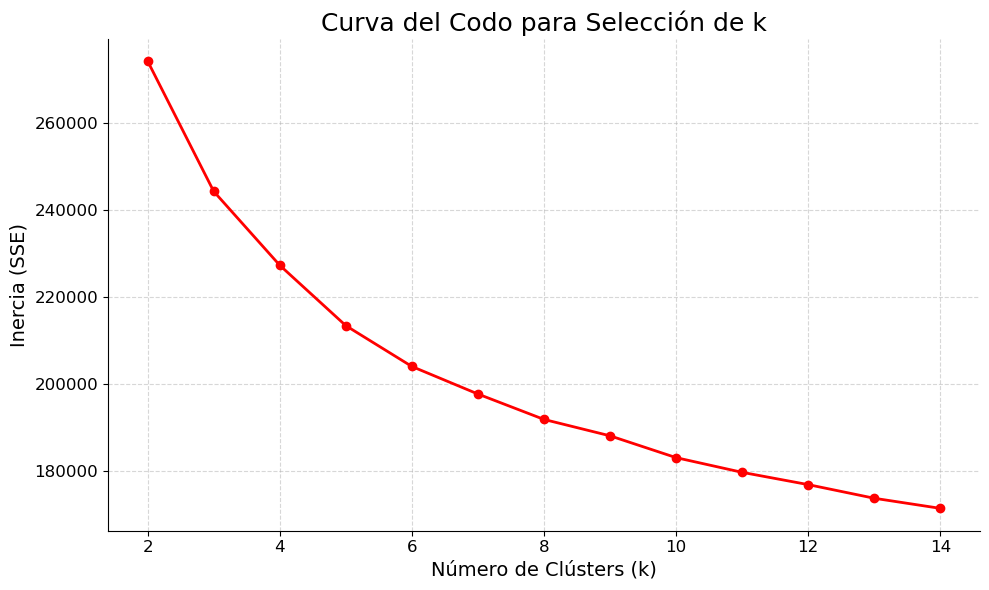

In [2072]:
import matplotlib.pyplot as plt

x_values = list(sse.keys())
y_values = list(sse.values())


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

# Línea de la curva del codo
ax.plot(x_values, y_values, color='red', marker='o', linewidth=2)

# Línea vertical en la k óptima
# ax.axvline(x=k_optima, color='gray', linestyle='--', linewidth=2)
#ax.text(k_optima + 0.1, max(y_values)*0.95, f'k óptima = {k_optima}', color='gray', fontsize=12)

# Etiquetas y estilo
ax.set_title("Curva del Codo para Selección de k", fontsize=18)
ax.set_xlabel("Número de Clústers (k)", fontsize=14)
ax.set_ylabel("Inercia (SSE)", fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


El valor optimo de k parece estar entre 5 y 6.

## Segmentación de los alumnos con k = 5

Empezaremos segmentando los alumnos con k=5.

In [2073]:

with mlflow.start_run(run_name=f"final_clustering_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):


    n_clusters = 5  # ejemplo, ajusta según los gráficos anteriores

    # Log parameters
    mlflow.log_param("n_clusters", n_clusters)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("features_used", list(df_scaled.columns))

    # Create and fit the final model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(df_scaled)
   # Calculate and log metrics
    mlflow.log_metric("final_sse", kmeans.inertia_)
    mlflow.log_metric("final_silhouette", silhouette_score(df_scaled, clusters))
    mlflow.log_metric("final_calinski", calinski_harabasz_score(df_scaled, clusters))
    
    # Log cluster sizes and characteristics
    cluster_sizes = pd.Series(clusters).value_counts()
    for cluster, size in cluster_sizes.items():
        mlflow.log_metric(f"final_cluster_{cluster}_size", size)
        
        # Log cluster statistics
        cluster_data = df_students_feat[clusters == cluster]
        for feature in df_scaled.columns:
            mlflow.log_metric(f"cluster_{cluster}_{feature}_mean", cluster_data[feature].mean())
            mlflow.log_metric(f"cluster_{cluster}_{feature}_std", cluster_data[feature].std())
    
    # Log the final model
    mlflow.sklearn.log_model(kmeans, "final_kmeans_model")


    # 3. Añadir los clusters al DataFrame original
    df_students_feat['cluster'] = clusters

2025/06/08 15:51:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [2074]:
# 4. Obtener los centroides en la escala original
centroids_original = inverse_transform_scaled_data(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(
    centroids_original,
    columns=df_students_feat.columns[:-1]  # excluimos la columna 'Cluster'
)

### Visualizaciones

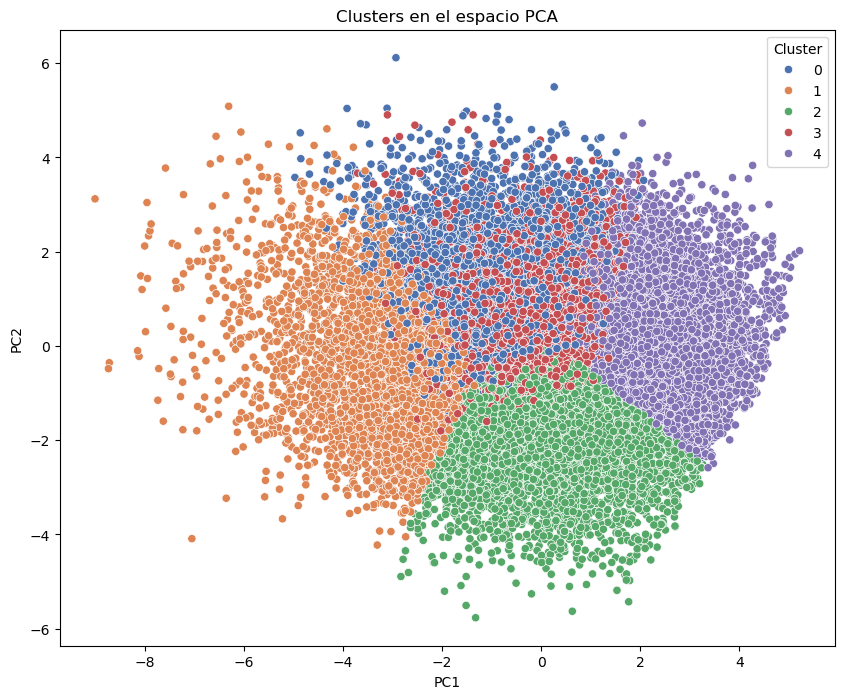

<Figure size 1200x600 with 0 Axes>

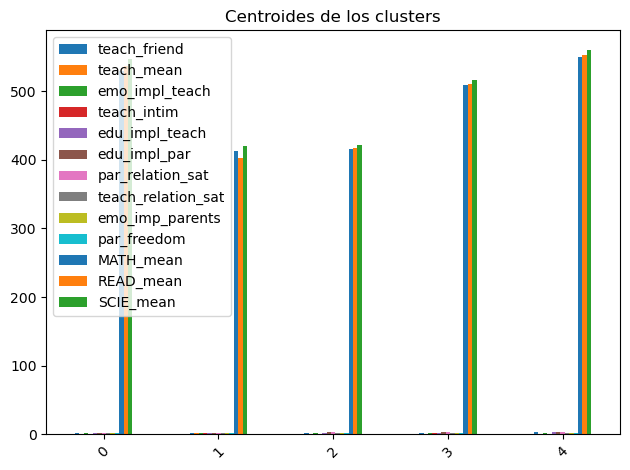

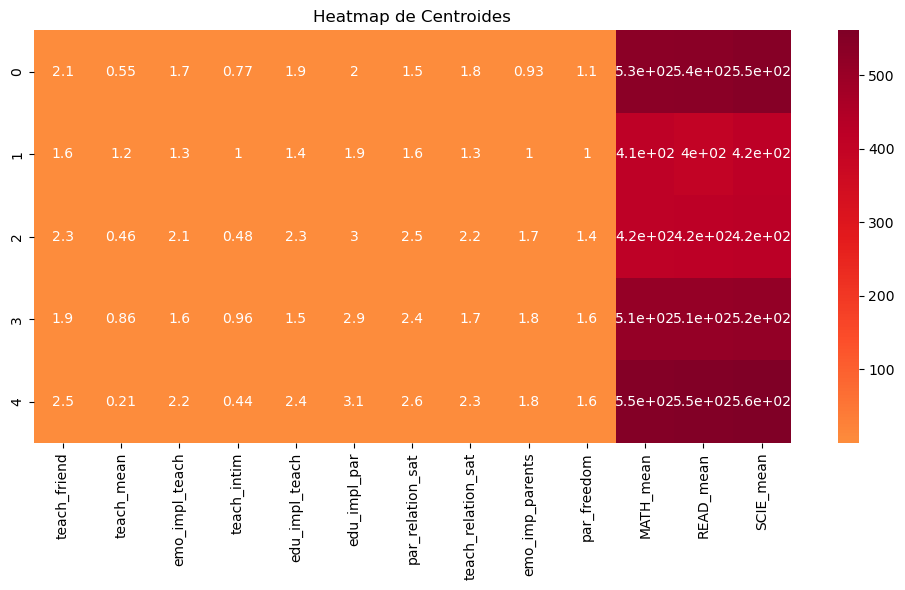

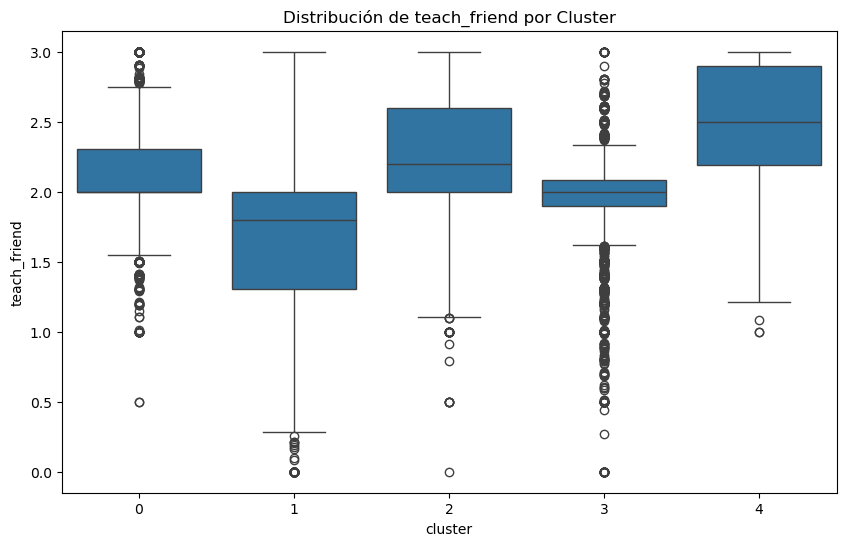

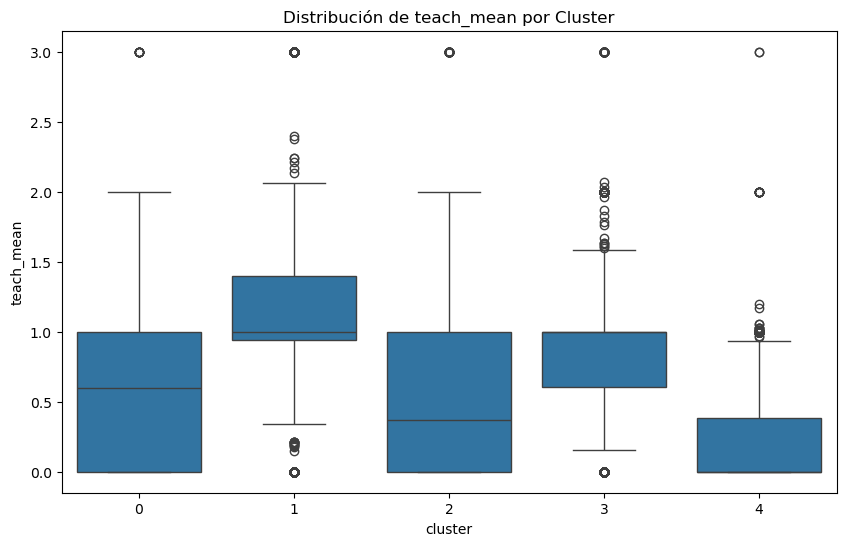

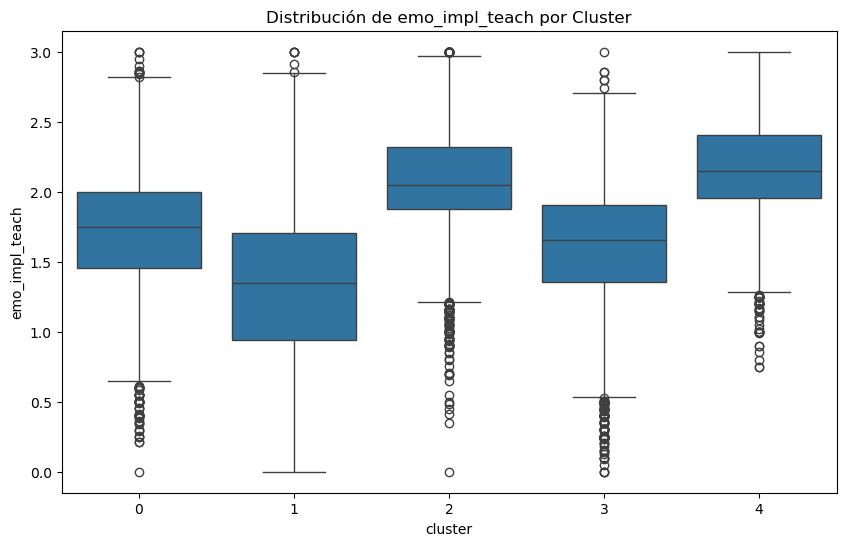

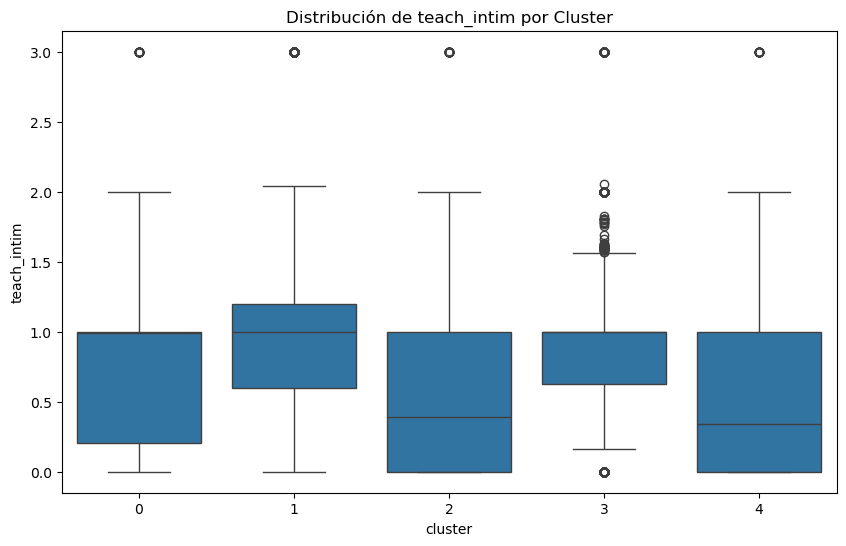

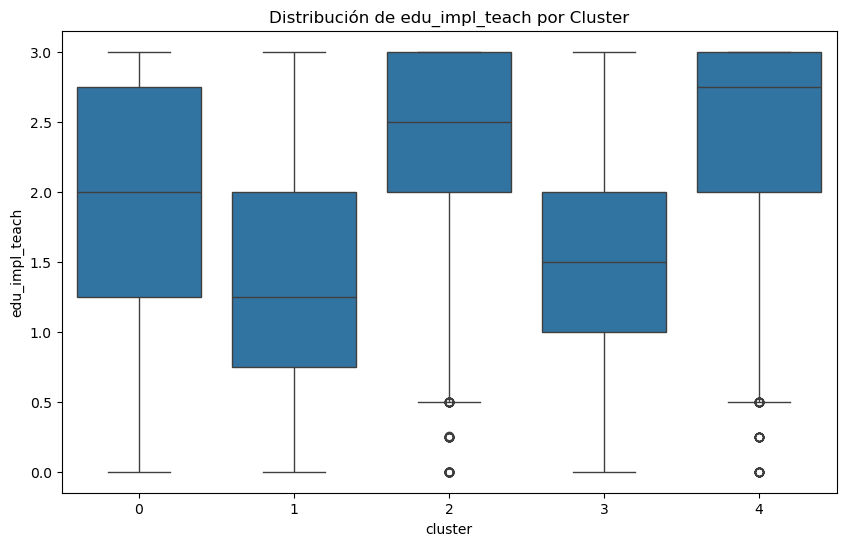

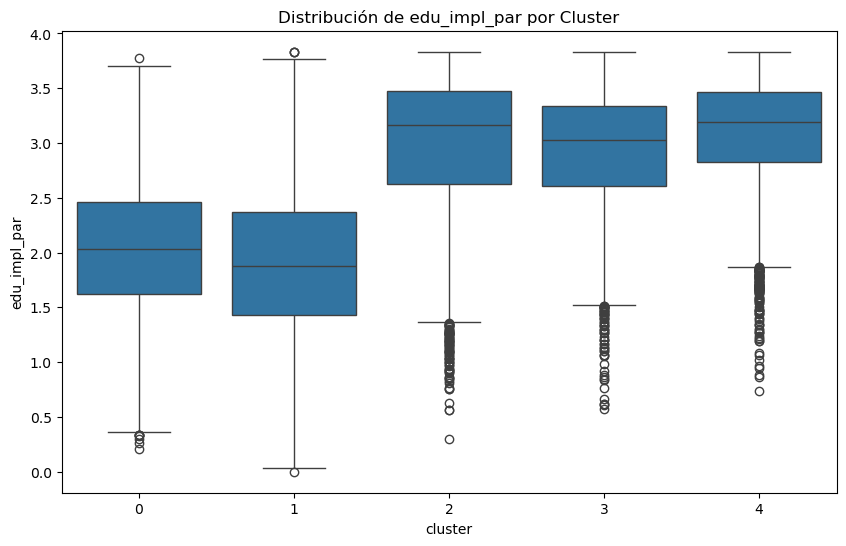

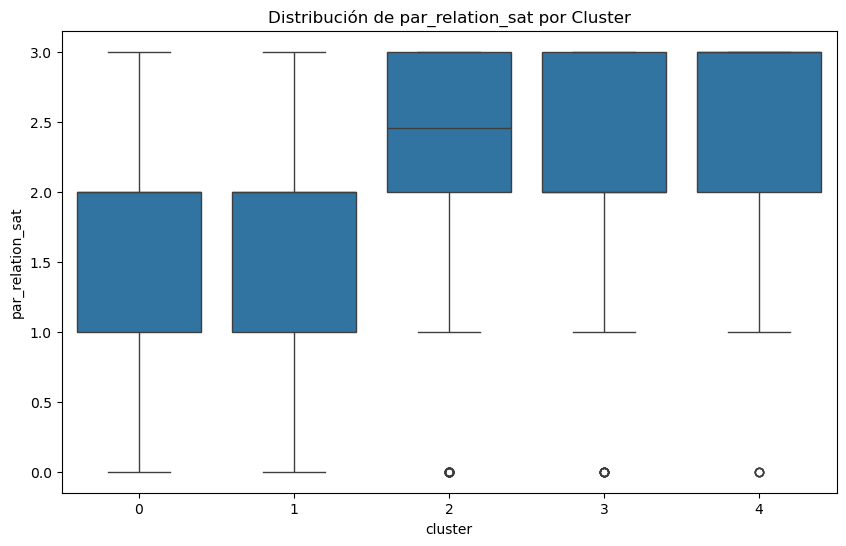

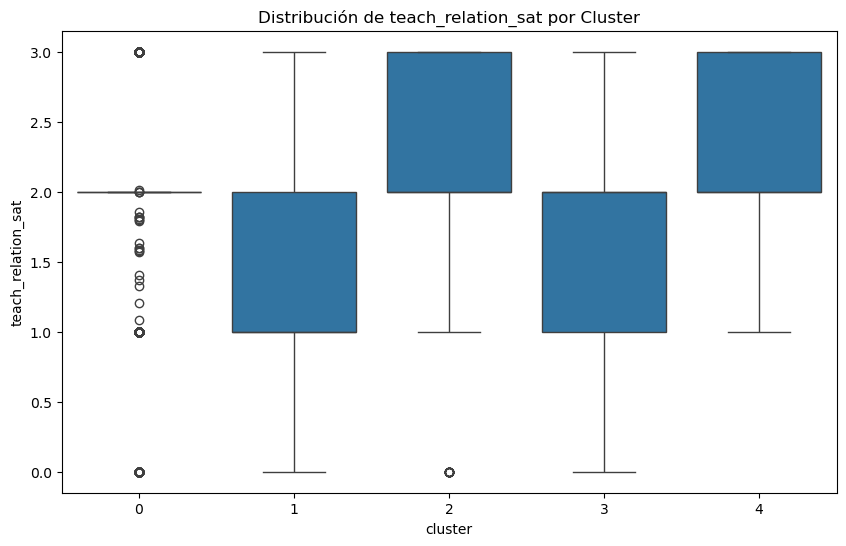

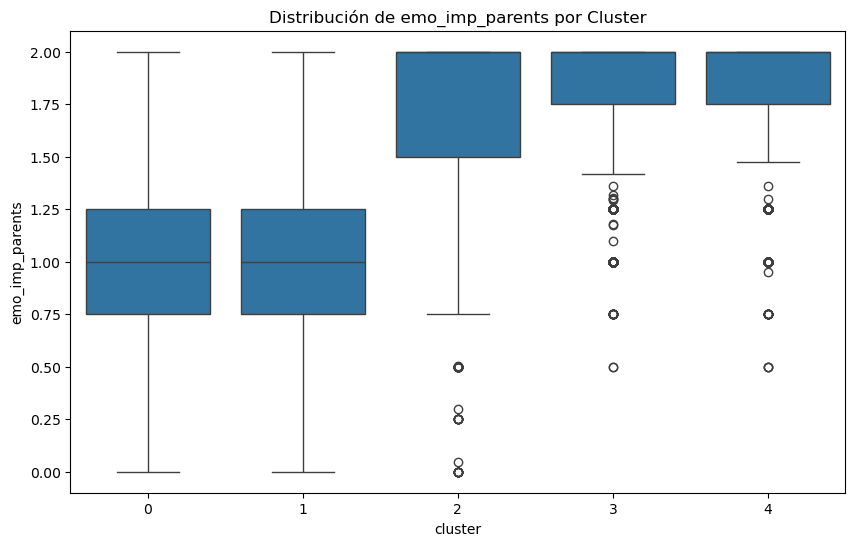

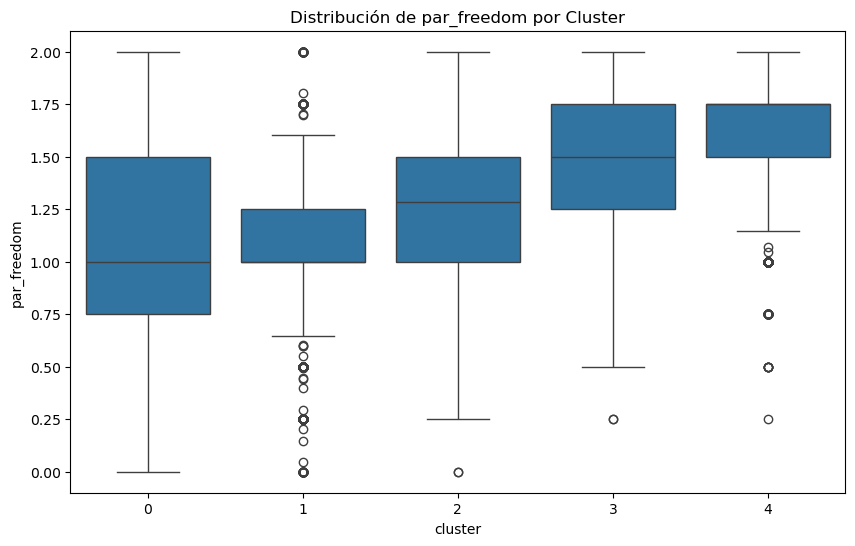

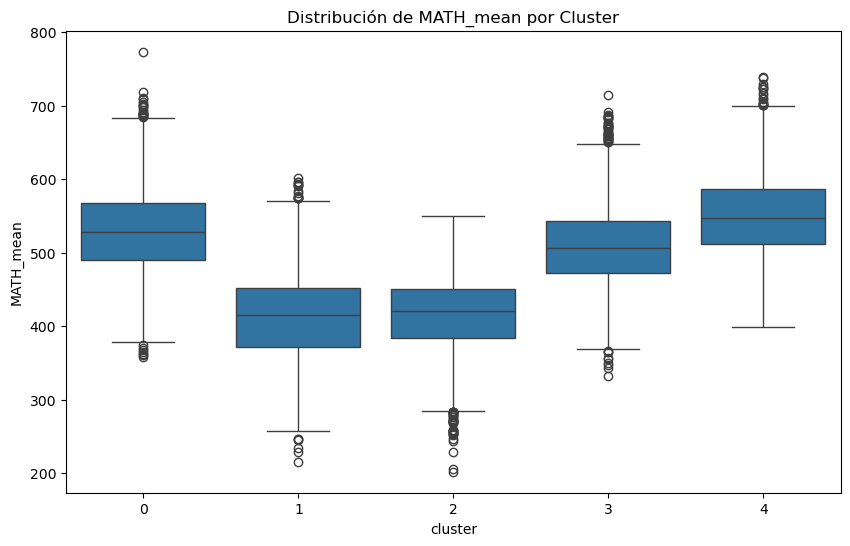

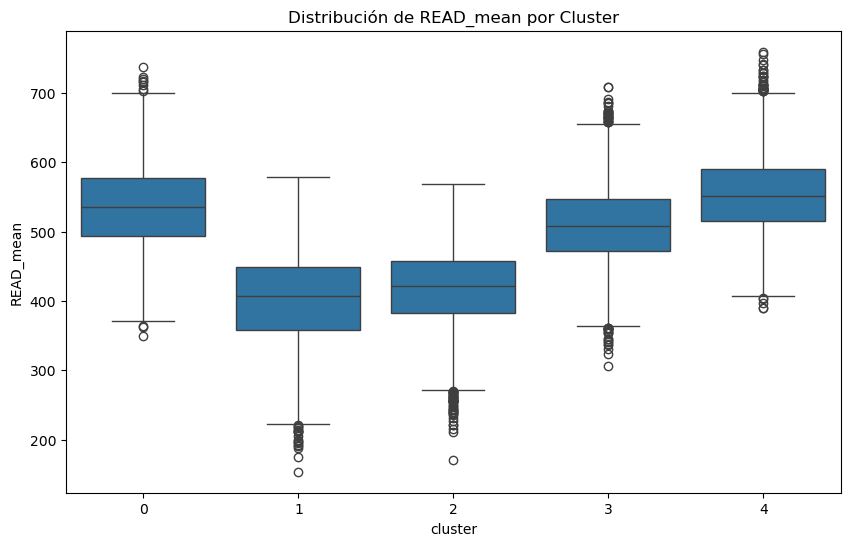

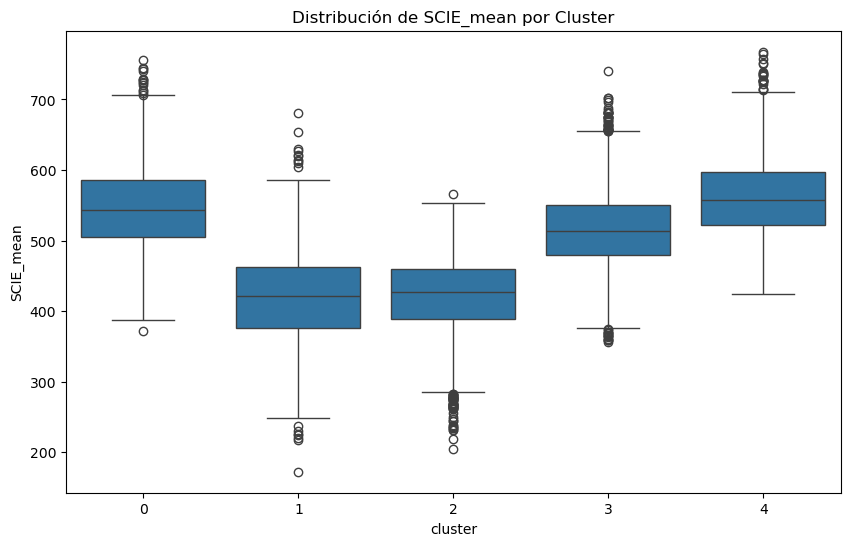


Tamaño de cada cluster:
0    4171
1    3492
2    6035
3    5757
4    6610
Name: cluster, dtype: int64

Características de cada cluster (en escala original):
   teach_friend  teach_mean  emo_impl_teach  ...   MATH_mean   READ_mean   SCIE_mean
0      2.135702    0.553940        1.706457  ...  530.355407  536.698723  546.639328
1      1.615156    1.167586        1.310430  ...  412.801560  403.106498  419.686585
2      2.313009    0.460187        2.089280  ...  415.663482  417.357954  421.263544
3      1.918921    0.864567        1.598437  ...  509.022883  510.506836  516.233534
4      2.513186    0.212965        2.184848  ...  550.437431  553.729761  561.007482

[5 rows x 13 columns]


In [2075]:

# 5. Visualizaciones

# 5.1. PCA para reducción de dimensionalidad y visualización
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = clusters

# Gráfico de dispersión con PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='deep')
plt.title('Clusters en el espacio PCA')
plt.show()

# 5.2. Visualización de los centroides
plt.figure(figsize=(12, 6))
centroids_df.plot(kind='bar')
plt.title('Centroides de los clusters')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5.3. Heatmap de los centroides
plt.figure(figsize=(10, 6))
sns.heatmap(centroids_df, annot=True, cmap='YlOrRd', center=0)
plt.title('Heatmap de Centroides')
plt.tight_layout()
plt.show()

# 5.4. Distribución de variables por cluster
for column in df_students_feat.columns[:-1]:  # excluimos la columna 'Cluster'
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=column, data=df_students_feat)
    plt.title(f'Distribución de {column} por Cluster')
    plt.show()

# 6. Análisis de los clusters
print("\nTamaño de cada cluster:")
print(df_students_feat['cluster'].value_counts().sort_index())

print("\nCaracterísticas de cada cluster (en escala original):")
print(centroids_df)



### Ficha de los estudiantes

Creamos una ficha resumen de cada grupo con las principales variables.

In [2076]:
ficha_df = pd.DataFrame()

In [2077]:
"""
#ficha sencilla
(
    df_imputed
    .groupby("cluster")
    .describe()
    .T
    .style
    .background_gradient(cmap = 'Blues', axis = 1)
)
"""

'\n#ficha sencilla\n(\n    df_imputed\n    .groupby("cluster")\n    .describe()\n    .T\n    .style\n    .background_gradient(cmap = \'Blues\', axis = 1)\n)\n'

In [2078]:
for i, col in enumerate(["emo_imp_parents",  "edu_impl_par", "par_freedom", "par_relation_sat", "emo_impl_teach", "edu_impl_teach", "teach_friend", "teach_mean",  "teach_intim"
                         , "teach_relation_sat",  "MATH_mean", "READ_mean", "SCIE_mean"]):
    resumen_data = df_students_feat[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = pd.concat([ficha_df, resumen_data])

In [2079]:
# generamos nuestro multiindex
out_index = [
    "Padres",
    "Padres",
    "Padres",
    "Padres",
    "Profesores",
    "Profesores",
    "Profesores",
    "Profesores",
    "Profesores",
    "Profesores",
    "Resultados académicos",
    "Resultados académicos", 
    "Resultados académicos"     
]

inner_index = [
    "Impl. emocional - padres",
    "Impl. educación - padres",
    "Libertad - padres",
    "Satisfacción relación - padres",
    "Impl. emocional - profesores",
    "Impl. educación - profesores",
    "Simpatía - profesores",
    "Maldad - profesores",
    "Intimidación - profesores",
    "Satisfacción relación - profesores",
    "VP matemáticas",
    "VP lectura",
    "VP ciencia"
]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]


new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))

In [2080]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [2081]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [2082]:
tamaño_clusters = df_students_feat.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [2083]:
ficha_df = pd.concat([tamaño_clusters, ficha_df])

In [2084]:
float_format = '{:.3f}'

"""
(
    ficha_df
    .style
    .format(float_format)
    .background_gradient(cmap = 'Blues', axis = 1)
)
"""

(
    ficha_df
    .rename(columns = {
        0:"Mala Implicación Padres<br>Buen Rendimiento",
        1:"Muy Mala Implicación<br>Muy Mal Rendimiento",
        2:"Buena Implicación<br>Mal Rendimiento",
        3:"Peor Implicación Profesores<br>Peor Rendimiento",
        4:"Muy Buena Implicación<br>Muy Buen Rendimiento",
    })
    .style
    .format(float_format)
    .background_gradient(cmap = 'Reds', axis = 1)
    .set_table_styles([
        {"selector": "th", "props": [("white-space", "normal"), ("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]},
        {"selector": "table", "props": [("table-layout", "fixed"), ("width", "100%")]}
    ])
)

In [2085]:
# Crear el HTML con gradiente horizontal por fila
styled_html = ficha_df.style.background_gradient(
    axis=1,  # Esto hace que el gradiente sea horizontal (por fila)
    cmap='RdYlGn',  # Puedes cambiar el mapa de colores
    vmin=None,  # Dejamos que pandas calcule automáticamente los mínimos
    vmax=None   # Dejamos que pandas calcule automáticamente los máximos
).set_properties(**{
    'border-color': 'lightgrey',
    'border-style': 'solid',
    'border-width': '1px',
    'text-align': 'center',
    'padding': '5px'
}).set_table_styles([
    {'selector': 'th',
     'props': [('background-color', '#f0f0f0'),
               ('color', 'black'),
               ('font-weight', 'bold'),
               ('text-align', 'center'),
               ('border', '1px solid lightgrey'),
               ('padding', '5px')]},
    {'selector': 'td',
     'props': [('border', '1px solid lightgrey'),
               ('padding', '5px')]}
]).to_html()

# Añadir estilos CSS adicionales
html_with_styles = f"""
<html>
<head>
<style>
    table {{
        border-collapse: collapse;
        width: 100%;
        margin: 20px 0;
    }}
    th, td {{
        text-align: center;
        padding: 8px;
    }}
    th {{
        background-color: #f0f0f0;
        color: black;
        font-weight: bold;
    }}
    tr:hover {{
        background-color: rgba(0,0,0,0.05);
    }}
</style>
</head>
<body>
{styled_html}
</body>
</html>
"""

# Guardar el HTML con estilos
html_path = 'ficha_styled.html'
with open(html_path, 'w', encoding='utf-8') as f:
    f.write(html_with_styles)

# Loggear en MLflow
mlflow.log_artifact(html_path)

Vamos a generar una ficha de resumen, solo con las medias para cada una de las variables.

In [2086]:
ficha_df2 = pd.DataFrame()

In [2087]:

for i, col in enumerate(["emo_imp_parents",  "edu_impl_par", "par_freedom", "par_relation_sat", "emo_impl_teach", "edu_impl_teach", "teach_friend", "teach_mean",  "teach_intim"
                         , "teach_relation_sat",  "MATH_mean", "READ_mean", "SCIE_mean"]):
    resumen_data = df_students_feat[["cluster", col]].groupby("cluster"). describe().T[1:]
    ficha_df2 = pd.concat([ficha_df2, resumen_data])

In [2088]:
ficha_df2

# Keep only mean rows from ficha_df
ficha_df2 = ficha_df2.loc[pd.IndexSlice[:,'mean'],:]

ficha_df2

,cluster,0,1,2,3,4
emo_imp_parents,mean,0.927903,0.999526,1.724000,1.790785,1.849960
edu_impl_par,mean,2.038449,1.908316,2.994396,2.938072,3.100639
par_freedom,mean,1.105395,1.024794,1.355528,1.556914,1.636817
par_relation_sat,mean,1.507640,1.615715,2.450158,2.394619,2.597305
emo_impl_teach,mean,1.706299,1.311415,2.090304,1.598210,2.184776
edu_impl_teach,mean,1.929058,1.413676,2.332746,1.498278,2.438821
teach_friend,mean,2.135618,1.616385,2.313678,1.918899,2.513096
teach_mean,mean,0.554288,1.167076,0.458758,0.864484,0.213231
teach_intim,mean,0.770494,0.998476,0.483113,0.957066,0.440903
teach_relation_sat,mean,1.785104,1.311300,2.200484,1.669812,2.293131


In [2089]:
# generamos nuestro multiindex
out_index = [
    "Padres",
    "Padres",
    "Padres",
    "Padres",
    "Profesores",
    "Profesores",
    "Profesores",
    "Profesores",
    "Profesores",
    "Profesores",
    "Resultados académicos",
    "Resultados académicos", 
    "Resultados académicos"     
]

inner_index = [
    "Impl. emocional - padres",
    "Impl. educación - padres",
    "Libertad - padres",
    "Satisfacción relación - padres",
    "Impl. emocional - profesores",
    "Impl. educación - profesores",
    "Simpatía - profesores",
    "Maldad - profesores",
    "Intimidación - profesores",
    "Satisfacción relación - profesores",
    "VP matemáticas",
    "VP lectura",
    "VP ciencia"
]

estadisticos = ["Media"]


new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))

In [2090]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [2091]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df2.set_index(index_ficha, inplace = True)

In [2092]:
tamaño_clusters = df_students_feat.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [2093]:
ficha_df2 = pd.concat([tamaño_clusters, ficha_df2])
# Eliminar la columna 'estadistico'


In [2094]:
# Crear el HTML con gradiente horizontal por fila
styled_html2 = ficha_df2.style.format("{:.4f}").background_gradient(
    axis=1,  # Esto hace que el gradiente sea horizontal (por fila)
    cmap='Blues',  # Mapa de colores azules
    vmin=None,  # Dejamos que pandas calcule automáticamente los mínimos
    vmax=None   # Dejamos que pandas calcule automáticamente los máximos
).set_properties(**{
    'border-color': 'lightgrey',
    'border-style': 'solid',
    'border-width': '1px',
    'text-align': 'center',
    'padding': '5px'
}).set_table_styles([
    {'selector': 'th',
     'props': [('background-color', '#f0f0f0'),
               ('color', 'black'),
               ('font-weight', 'bold'),
               ('text-align', 'center'),
               ('border', '1px solid lightgrey'),
               ('padding', '5px')]},
    {'selector': 'td',
     'props': [('border', '1px solid lightgrey'),
               ('padding', '5px')]}
]).to_html()

# Añadir estilos CSS adicionales
html_with_styles2 = f"""
<html>
<head>
<style>
    table {{
        border-collapse: collapse;
        width: 100%;
        margin: 20px 0;
    }}
    th, td {{
        text-align: center;
        padding: 8px;
    }}
    th {{
        background-color: #f0f0f0;
        color: black;
        font-weight: bold;
    }}
    tr:hover {{
        background-color: rgba(0,0,0,0.05);
    }}
</style>
</head>
<body>
{styled_html2}
</body>
</html>
"""

# Guardar el HTML con estilos
html_path2 = 'ficha_styled2.html'
with open(html_path2, 'w', encoding='utf-8') as f:
    f.write(html_with_styles2)
            
# Loggear en MLflow
mlflow.log_artifact(html_path2)

In [2095]:

float_format = '{:.2f}'
ficha_df2 = ficha_df2.round(2)


# Eliminamos el nivel "Estadístico" del índice
ficha_df2.index = ficha_df2.index.droplevel("Estadístico")


(
    ficha_df2
    .rename(columns = {
        0:"Mala Implicación Padres<br>Buen Rendimiento",
        1:"Muy Mala Implicación<br>Muy Mal Rendimiento",
        2:"Buena Implicación<br>Mal Rendimiento",
        3:"Peor Implicación Profesores<br>Peor Rendimiento",
        4:"Muy Buena Implicación<br>Muy Buen Rendimiento",
    })
    .style
    .format(float_format)
    .background_gradient(cmap = 'Reds', axis = 1)
    .set_table_styles([
        {"selector": "th", "props": [("white-space", "normal"), ("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]},
        {"selector": "table", "props": [("table-layout", "fixed"), ("width", "100%")]}
    ])
)

## Guardamos

In [2096]:
import json
import joblib
import pandas as pd
import numpy as np
from datetime import datetime

# 1. Crear directorio para guardar los resultados si no existe
import os
if not os.path.exists('C:\\Users\\saraf\\OneDrive\\Documentos\\Data Science and AI\\capstone project\\data\\processed\\clustering_results'):
    os.makedirs('C:\\Users\\saraf\\OneDrive\\Documentos\\Data Science and AI\\capstone project\\data\\processed\\clustering_results')

# 2. Guardar el modelo KMeans
joblib.dump(kmeans, 'C:\\Users\\saraf\\OneDrive\\Documentos\\Data Science and AI\\capstone project\\data\\processed\\clustering_results\\kmeans_model.joblib')

# 3. Guardar los parámetros del clustering
clustering_params = {
    'n_clusters': kmeans.n_clusters,
    'random_state': kmeans.random_state,
    'n_init': kmeans.n_init,
    'max_iter': kmeans.max_iter,
    'algorithm': kmeans.algorithm,
    'variables_used': list(df_scaled.columns),
    'date_created': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('C:\\Users\\saraf\\OneDrive\\Documentos\\Data Science and AI\\capstone project\\data\\processed\\clustering_results\\clustering_params.json', 'w') as f:
    json.dump(clustering_params, f, indent=4)

# 4. Guardar los datos con los clusters
df_students_feat.to_csv('C:\\Users\\saraf\\OneDrive\\Documentos\\Data Science and AI\\capstone project\\data\\processed\\clustering_results\\df_students_clustered_well.csv', index=False)



In [2097]:
mlflow.end_run()